# Yield Prediction using RDkit Descriptor

## 1) Dataset Description 

This dataset originates from a recent publication by a Pfizer team. Utilizing flow chemistry, they conducted a high-throughput reaction screening of the Suzuki–Miyaura C–C coupling reaction. This screening involved 11 reactants, 12 ligands, 8 bases, and 4 solvents, resulting in a total of 5760 reactions. The predictive target in this dataset is the reaction yield. (D. Perera, J. W. Tucker, S. Brahmbhatt, C. J. Helal, A. Chong, W. Farrell, P. Richardson and N. W. Sach, Science, 2018, 359, 429–434.)

The objective of this notebook is to introduce a method for predicting yiel using RDkit descriptors and non-linear model (XGBoost).

As a beginner, there may be numerous opportunities for improvement in this notebook. 
I was largely inspired by the work of Alexander A. Ksenofontov and co (10.1016/j.jocs.2023.102173) and the André OLIVEIRA's notebook (Predicting molecule properties based on its SMILES), thanks to them. 

In [7]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import os 
import sys
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.ML.Descriptors.Descriptors import DescriptorCalculator
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
import shap
import cairo
import pandas as pd
import seaborn as sns
IPythonConsole.molSize = (300, 300)
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
shap.initjs()

# DL Dataset

In [8]:
data = r"..\data\Suzuki-Miyaura\aap9112_Data_File_S1.xlsx"

dataF = pd.read_excel(data)

df = dataF.copy()

In [9]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 16)

In [10]:
df.head(100)

,Reaction_No,Reactant_1_Name,Reactant_1_Short_Hand,Reactant_1_eq,Reactant_1_mmol,Reactant_2_Name,Reactant_2_eq,Catalyst_1_Short_Hand,Catalyst_1_eq,Ligand_Short_Hand,Ligand_eq,Reagent_1_Short_Hand,Reagent_1_eq,Solvent_1_Short_Hand,Product_Yield_PCT_Area_UV,Product_Yield_Mass_Ion_Count
0,1,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(tBu)3,0.125,NaOH,2.5,MeCN,4.764109,6262.058822
1,2,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(Ph)3,0.125,NaOH,2.5,MeCN,4.120962,13245.570909
2,3,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,AmPhos,0.125,NaOH,2.5,MeCN,2.583837,3009.165946
3,4,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(Cy)3,0.125,NaOH,2.5,MeCN,4.443171,30860.698262
4,5,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(o-Tol)3,0.125,NaOH,2.5,MeCN,1.949874,2486.306423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,NaN,NaN,NaN,2.5,MeCN,8.287404,28481.361326
96,97,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(tBu)3,0.125,NaOH,2.5,THF,33.788423,46748.738785
97,98,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,P(Ph)3,0.125,NaOH,2.5,THF,8.083894,9823.262022
98,99,6-chloroquinoline,"1a, 6-Cl-Q",1,0.0004,"2a, Boronic Acid",1,Pd(OAc)2,0.0625,AmPhos,0.125,NaOH,2.5,THF,61.200081,65207.403433


In [11]:
df.shape

(5760, 16)

# Replace molecule's label by SMILES (found thanks to Chemspider)

I chose SMILES for molecular representation

In [12]:
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-chloroquinoline", "c1cc2cc(ccc2nc1)Cl")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Bromoquinoline", "c1cc2cc(ccc2nc1)Br")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-triflatequinoline", "c1cc2cc(ccc2nc1)OS(=O)(=O)C(F)(F)F")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Iodoquinoline", "c1cc2cc(ccc2nc1)I")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-quinoline-boronic acid hydrochloride", "B(c1ccc2c(c1)cccn2)(O)O.Cl")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("Potassium quinoline-6-trifluoroborate", "[B-](c1ccc2c(c1)cccn2)(F)(F)F.[K+]")
df["Reactant_1_Name"] = df["Reactant_1_Name"].replace("6-Quinolineboronic acid pinacol ester", "B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3")

In [13]:
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2a, Boronic Acid", "B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2b, Boronic Ester", "B1(OC(C(O1)(C)C)(C)C)c2c(ccc3c2cnn3C4CCCCO4)C")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2c, Trifluoroborate", "CCc1cccc(CC)c1.Cc1ccc2c(cnn2C2CCCCO2)c1[B-](F)(F)F.[K+]")
df["Reactant_2_Name"] = df["Reactant_2_Name"].replace("2d, Bromide", "Cc1ccc2c(c1Br)cnn2C3CCCCO3")

In [14]:
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(tBu)3", "CC(C)(C)P(C(C)(C)C)C(C)(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(Ph)3 ", "c1ccc(cc1)P(c2ccccc2)c3ccccc3")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("AmPhos", "P(c1ccc(cc1)N(C)C)(C(C)(C)C)C(C)(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(Cy)3", "C1CCC(CC1)P(C2CCCCC2)C3CCCCC3")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("P(o-Tol)3", "Cc1ccccc1P(c2ccccc2C)c3ccccc3C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("CataCXium A", "P(C13CC2CC(C1)CC(C2)C3)(CCCC)C46CC5CC(CC(C4)C5)C6")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("SPhos", "COc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("dtbpf", "CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.[Fe]")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("XPhos", "CC(C)c1cc(c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CCCCC4)C(C)C")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("dppf", "c1ccc(cc1)P(c2ccccc2)C34C5[Fe]3678912(C5C6C74)C3C8C9C1(C23)P(c1ccccc1)c1ccccc1")
df["Ligand_Short_Hand"] = df["Ligand_Short_Hand"].replace("Xantphos", "CC1(c2cccc(c2Oc3c1cccc3P(c4ccccc4)c5ccccc5)P(c6ccccc6)c7ccccc7)C")

In [15]:
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("NaOH", "[OH-].[Na+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("NaHCO3", "C(=O)(O)[O-].[Na+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("CsF", "[F-].[Cs+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("K3PO4", "[O-]P(=O)([O-])[O-].[K+].[K+].[K+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("KOH", "[OH-].[K+]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("LiOtBu", "[Li+].CC(C)(C)[O-]")
df["Reagent_1_Short_Hand"] = df["Reagent_1_Short_Hand"].replace("Et3N", "CCN(CC)CC")

In [16]:
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeCN", "CC#N")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("DMF", "CN(C)C=O")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("THF", "C1CCOC1")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeOH", "CO")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("MeOH/H2O_V2 9:1", "CO")
df["Solvent_1_Short_Hand"] = df["Solvent_1_Short_Hand"].replace("THF_V2", "CO")

In [17]:
df["Catalyst_1_Short_Hand"] = df["Catalyst_1_Short_Hand"].replace("Pd(OAc)2", "CC(=O)[O-].CC(=O)[O-].[Pd+2]")

# Creat the Product Feature

In [18]:
df["Product"] = "Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1"  # SMILE obtaint thanks to Chemdraw 

In [19]:
#Method transforms smiles strings to mol rdkit object
df['mol'] = df['Product'].apply(lambda x: Chem.MolFromSmiles(x))

#Now let's see what we've got
print(df['mol'][0])

#Now let's see what we've got
print(type(df['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


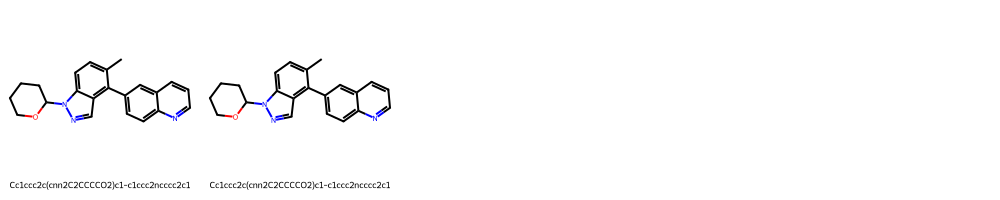

In [20]:
mols = df['mol'][:2]

#MolsToGridImage allows to paint a number of molecules at a time
img = Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['Product'][:2].values))
img

In [21]:
df.head()

,Reaction_No,Reactant_1_Name,Reactant_1_Short_Hand,Reactant_1_eq,Reactant_1_mmol,Reactant_2_Name,Reactant_2_eq,Catalyst_1_Short_Hand,...,Ligand_eq,Reagent_1_Short_Hand,Reagent_1_eq,Solvent_1_Short_Hand,Product_Yield_PCT_Area_UV,Product_Yield_Mass_Ion_Count,Product,mol
0,1,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,0.125,[OH-].[Na+],2.5,CC#N,4.764109,6262.058822,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000240EAF...
1,2,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,0.125,[OH-].[Na+],2.5,CC#N,4.120962,13245.570909,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000240EAF...
2,3,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,0.125,[OH-].[Na+],2.5,CC#N,2.583837,3009.165946,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000240EAF...
3,4,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,0.125,[OH-].[Na+],2.5,CC#N,4.443171,30860.698262,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000240EAF...
4,5,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,0.125,[OH-].[Na+],2.5,CC#N,1.949874,2486.306423,Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1,<rdkit.Chem.rdchem.Mol object at 0x00000240EAF...


# Drawing Chemical Reaction (For Fun)

In [22]:
from rdkit.Chem import Draw
from IPython.display import display, Image  # Import Image class
#import cairo
import io

# creat reaction
rxn = AllChem.ReactionFromSmarts('[#6]1:[#6]:[#6]2:[#6]:[#6](:[#6]:[#6]:[#6]:2:[#7]:[#6]:1)-[#17].[#5](-[#6]1:[#6]:[#6]2:[#6](:[#6]:[#6]:1-[#6]):[#6]:[#7]:[#7]:2-[#6]1-[#6]-[#6]-[#6]-[#6]-[#8]-1)(-[#8])-[#8]>[#6]-[#6](=[#8])-[#8-].[#6]-[#6](=[#8])-[#8-].[Pd+2].[#6]-[#6](-[#6])(-[#6])-[#15](-[#6](-[#6])(-[#6])-[#6])-[#6](-[#6])(-[#6])-[#6].[#8H-].[Na+].[#6]-[#6]#[#7]>[#6]-[#6]1:[#6]:[#6]:[#6]2:[#6](:[#6]:[#7]:[#7]:2-[#6]2-[#6]-[#6]-[#6]-[#6]-[#8]-2):[#6]:1-[#6]1:[#6]:[#6]:[#6]2:[#7]:[#6]:[#6]:[#6]:[#6]:2:[#6]:1')

d2d = Draw.MolDraw2DCairo(800,300)
d2d.DrawReaction(rxn)
png = d2d.GetDrawingText()

# Convert the PNG image data to bytes
png_bytes = io.BytesIO(png)

# Create an Image object and display it in the notebook
img = Image(data=png_bytes.getvalue())
type(img)

IPython.core.display.Image

In [23]:
print("Number of Agent",rxn.GetNumAgentTemplates()) # Number of Agent
print("Number of Product",rxn.GetNumProductTemplates()) # Number of Product
print("Number of Reactant",rxn.GetNumReactantTemplates()) # Number of Reactant

Number of Agent 7
Number of Product 1
Number of Reactant 2


## Creat all chemical reaction SMILE

In [24]:
df["Ligand_Short_Hand"].fillna("", inplace=True)
df["Reagent_1_Short_Hand"].fillna("", inplace=True)

df["Chemical_react"] = df["Reactant_1_Name"].str.cat(df["Reactant_2_Name"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Solvent_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Catalyst_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Reagent_1_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Ligand_Short_Hand"], sep='.')
df["Chemical_react"] = df["Chemical_react"].str.cat(df["Product"], sep='>>')


In [25]:
df["Chemical_react"][0]

'c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2].[OH-].[Na+].CC(C)(C)P(C(C)(C)C)C(C)(C)C>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

In [26]:
df["Chemical_react"][4999]

'[B-](c1ccc2c(c1)cccn2)(F)(F)F.[K+].Cc1ccc2c(c1Br)cnn2C3CCCCO3.CO.CC(=O)[O-].CC(=O)[O-].[Pd+2]..CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.[Fe]>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

In [27]:
df["Chemical_react"][93]

'c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2]..c1ccc(cc1)P(c2ccccc2)C34C5[Fe]3678912(C5C6C74)C3C8C9C1(C23)P(c1ccccc1)c1ccccc1>>Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

# RDKit Descriptor

In [28]:
from rdkit.Chem import Descriptors

In [29]:
df['Chemical_react'] = df['Chemical_react'].replace('>>', '.', regex=True)

In [30]:
df['Chemical_react'][0]

'c1cc2cc(ccc2nc1)Cl.B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O.CC#N.CC(=O)[O-].CC(=O)[O-].[Pd+2].[OH-].[Na+].CC(C)(C)P(C(C)(C)C)C(C)(C)C.Cc1ccc2c(cnn2C2CCCCO2)c1-c1ccc2ncccc2c1'

In [31]:
def calculate_descriptors(df):
    descriptor_names = list(Chem.rdMolDescriptors.Properties.GetAvailableProperties())
    descriptor_names.remove('exactmw')
    for name in descriptor_names:
        df[name] = df['Chemical_react'].apply(lambda x: descriptor(name, x))
    return df

In [32]:
def descriptor(descriptor:str, smi:str)->float:
    get_descriptors = Chem.rdMolDescriptors.Properties([descriptor])
    try:
        return get_descriptors.ComputeProperties(Chem.MolFromSmiles(smi))[0]
    except:
        return None

In [33]:
def filter_descriptors(data, threshold): # to avoid multicolinearity 
    descriptors = data.drop(df.columns[:19], axis=1)
    corr = descriptors.copy().corr()
    for index in corr.index:
        corr.loc[index, index] = 0
    descriptors_not_correlated = corr[(corr <= threshold)].index.tolist()
    print('Number of descriptors:', len(descriptors_not_correlated) - 1)
    return data[descriptors_not_correlated], data['Product_Yield_PCT_Area_UV']

In [34]:
calculate_descriptors(df)

,Reaction_No,Reactant_1_Name,Reactant_1_Short_Hand,Reactant_1_eq,Reactant_1_mmol,Reactant_2_Name,Reactant_2_eq,Catalyst_1_Short_Hand,...,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,1,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,12.576487,12.576487,10.703363,-4.682727,76.330041,35.696786,23.602821,32.828158
1,2,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,13.607204,13.607204,9.863081,-7.022727,74.441340,38.507963,21.868053,32.208813
2,3,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,13.529973,13.529973,10.365345,-5.662727,78.432692,37.486998,23.294123,33.411434
3,4,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,16.553024,16.553024,12.716642,-4.682727,76.769077,40.329301,23.135110,34.787002
4,5,c1cc2cc(ccc2nc1)Cl,"1a, 6-Cl-Q",1,0.0004,B(c1cc2c(cc1C)cnn2C3CCCCO3)(O)O,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,14.633097,14.633097,10.516904,-7.022727,77.425734,38.861740,21.518746,32.705421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,5756,B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3,"1f, 6-BPin-Q",1,0.0004,Cc1ccc2c(c1Br)cnn2C3CCCCO3,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,17.498457,17.498457,13.140417,0.495844,113.495844,52.316707,37.454988,52.546273
5756,5757,B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3,"1f, 6-BPin-Q",1,0.0004,Cc1ccc2c(c1Br)cnn2C3CCCCO3,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,21.528719,21.528719,15.139891,-2.013636,108.319146,52.317721,31.778454,48.025516
5757,5758,B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3,"1f, 6-BPin-Q",1,0.0004,Cc1ccc2c(c1Br)cnn2C3CCCCO3,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,32.410853,32.410853,29.457772,-2.624156,94.490796,28.693309,8.514489,22.407055
5758,5759,B1(OC(C(O1)(C)C)(C)C)c2ccc3c(c2)cccn3,"1f, 6-BPin-Q",1,0.0004,Cc1ccc2c(c1Br)cnn2C3CCCCO3,1,CC(=O)[O-].CC(=O)[O-].[Pd+2],...,21.087301,21.087301,14.563503,-4.903636,108.124613,50.812133,28.813790,43.603509


In [35]:
data1 = df.dropna(axis=0) # Delete missing value

In [36]:
data1.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758],
      dtype='int64', length=4620)

In [37]:
data1.reset_index(drop=True, inplace=True) # To avoid indexing problem

In [38]:
data1.index

RangeIndex(start=0, stop=4620, step=1)

# MODEL XGBOOST

XGBoost is based on the concept of boosting, where multiple models (called "weak learners") are trained sequentially. Each model tries to correct the mistakes of the ones before it.

The models are decesion tree

In [39]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.model_selection import learning_curve

In [40]:
X, y = filter_descriptors(data1, threshold=0.5)

Number of descriptors: 41


In [41]:
X.shape

(4620, 42)

In [42]:
y.shape

(4620,)

In [43]:
y = y.apply(lambda x: x/100)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3696, 42)
(924, 42)
(3696,)
(924,)


In [46]:
model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=12,
                min_child_weight=6,
                colsample_bytree=0.6,
                subsample=0.8,
                random_state=42,
            )

In [47]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Root Mean Squared Error:", rmse) 
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()
     

Mean Squared Error: 0.040853964195011735
R-squared: 0.5121620747350932
Root Mean Squared Error: 0.20212363591379345


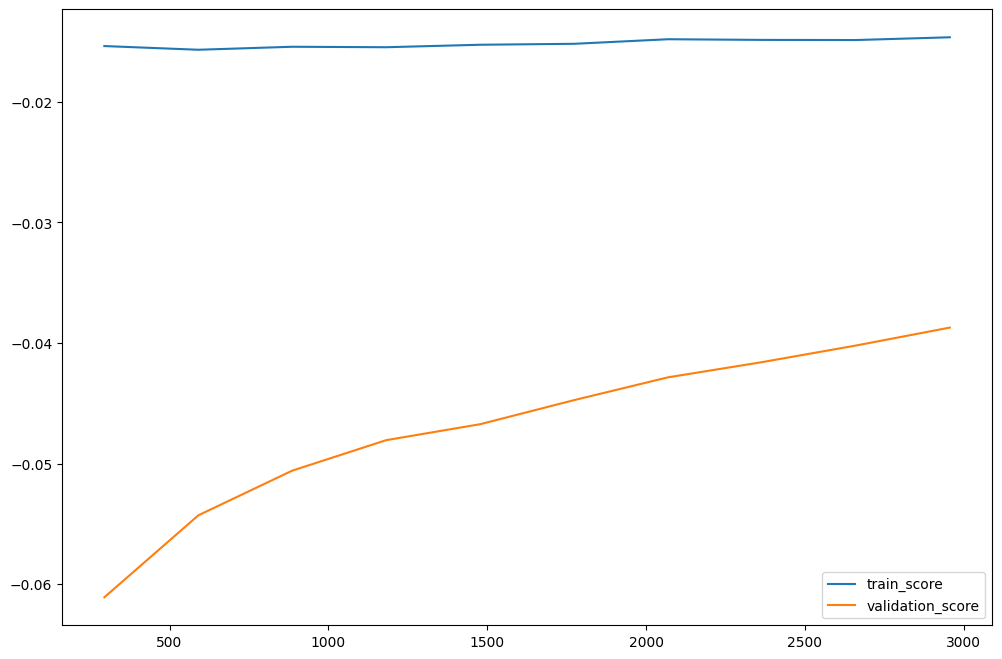

In [48]:
evaluation(model)

The results are not very high, but in comparison with the results of Alexander A., who used a different dataset but the same method with RDKit descriptors (only 13 descriptors, whereas we have retained 41), and a roughly similar model, our results are of the same order of magnitude:

Alexander's result :

(Number of descriptors: 13 )

Random Forest Regression:

Average performance of test set at 10 split

Metric
R^2	0.56
RMSE 13.99

# Explaining Model 

SHAP values can help you understand how model features impact predictions (works on Gradient boosting models). 

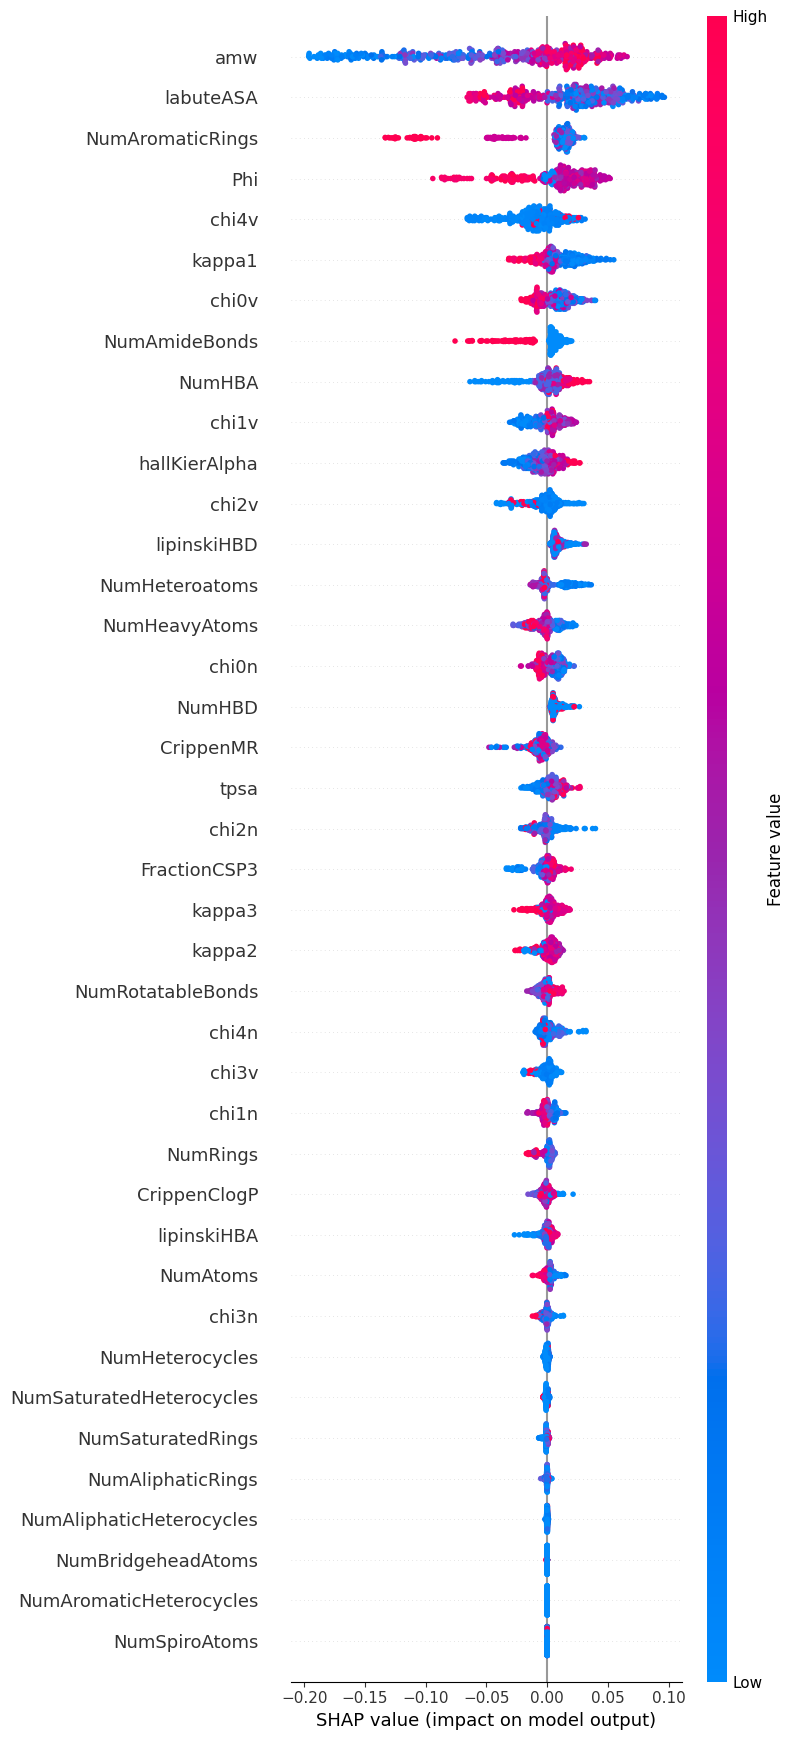

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:500])
shap.summary_plot(shap_values, X[:500], max_display=40)
pickle.dump((shap_values, X[:500]), open("shap_values.pkl", "wb"))

If we examine the feature "amw," we can say that higher values positively impact the model, whereas lower values negatively impact the model."amw" = "Average molecular weight"

Afterward, we can examine the impact of each feature on the reactions. 

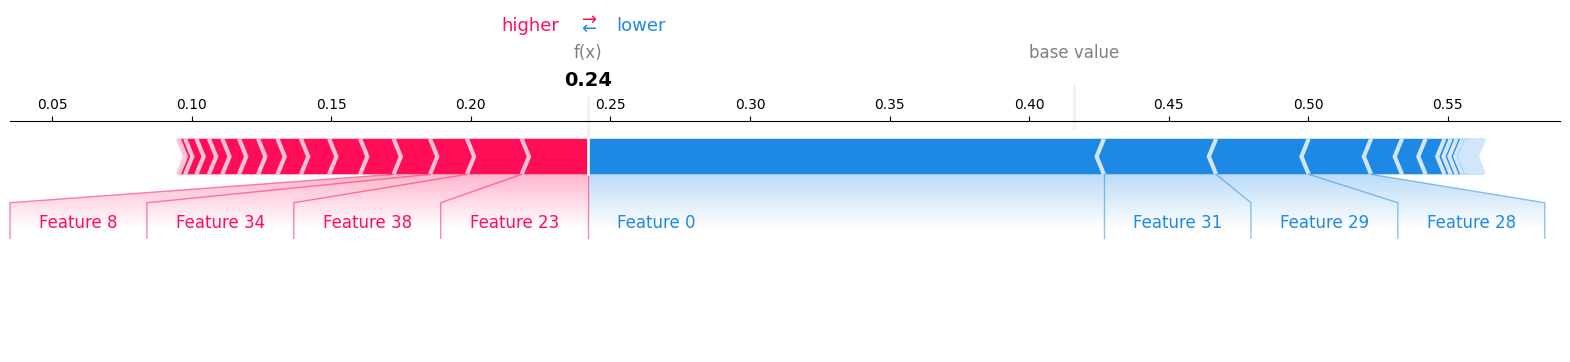

In [50]:
shap.force_plot(explainer.expected_value, shap_values[0,:], matplotlib=True)

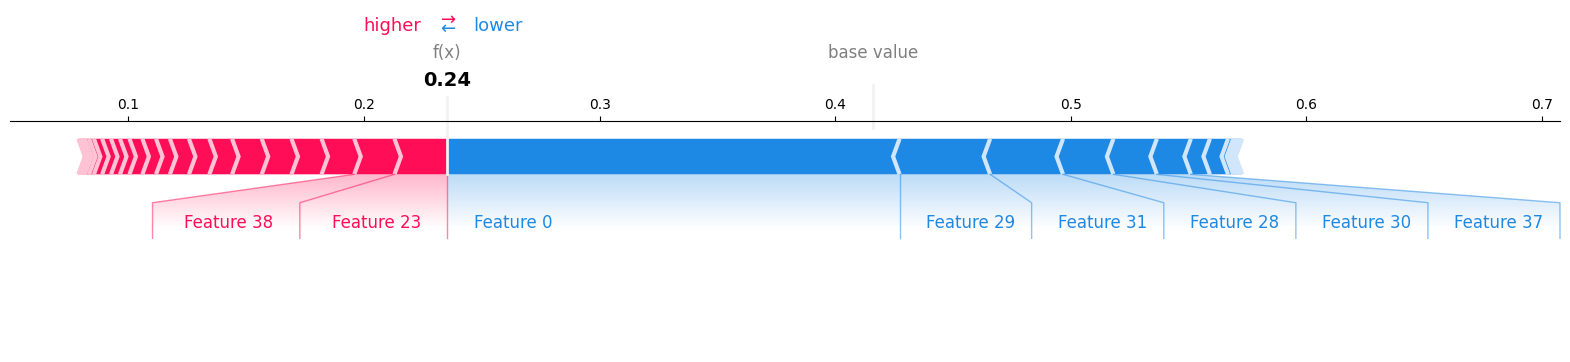

In [51]:
shap.force_plot(explainer.expected_value, shap_values[1,:], matplotlib=True)

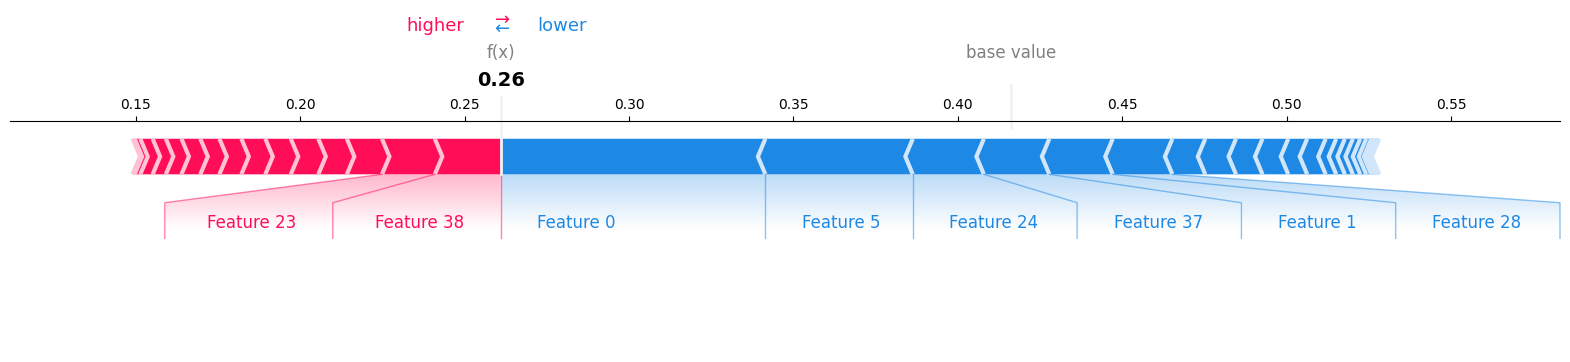

In [52]:
shap.force_plot(explainer.expected_value, shap_values[100,:], matplotlib=True)

We can see in these three examples that the feature "amw" has a negative impact.

There's still a huge amount of analysis to be done, so I'm just presenting a few results here.

Thanks 